In [1]:
import numpy as np
import math
#import matplotlib.pyplot as plt
import pylab as plt
import geopandas as gpd
from shapely.geometry.polygon import LinearRing
from MinimumBoundingBox import minimum_bounding_box
import subprocess as sp
import os
from shapely.geometry import Point
from functools import partial
import pyproj
from shapely.ops import transform
import pandas as pd
from xml.etree.ElementTree import Element, SubElement, Comment
from xml.etree import ElementTree
from xml.dom import minidom
import re
import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas.tools import sjoin
%matplotlib inline

In [2]:
non_decimal = re.compile(r'[^\d.,-]+')

rootOgrGdal = r'C:\Python35\Lib\site-packages\osgeo'
ogr2ogr = os.path.join(rootOgrGdal, 'ogr2ogr.exe')
gdalwarp = os.path.join(rootOgrGdal, 'gdalwarp.exe')
gdal_rasterize = os.path.join(rootOgrGdal, 'gdal_rasterize.exe')
gdal_translate = os.path.join(rootOgrGdal, 'gdal_translate.exe')
gdalbuildvrt = os.path.join(rootOgrGdal, 'gdalbuildvrt.exe')
gdalinfo = os.path.join(rootOgrGdal, 'gdalinfo.exe')
ogrinfo = os.path.join(rootOgrGdal, 'ogrinfo.exe')
gdal_grid = os.path.join(rootOgrGdal, 'gdal_grid.exe')
gdal_edit = os.path.join(rootOgrGdal,'scripts', 'gdal_edit.py')

In [3]:
# rotation function
def Rotate2D(pts,cnt,ang=np.pi/4):
    '''pts = {} Rotates points(nx2) about center cnt(2) by angle ang(1) in radian'''
    return np.dot(pts-cnt,np.array([[math.cos(ang),math.sin(ang)],[-math.sin(ang),math.cos(ang)]]))+cnt

# set transform object to go from wgs to rd
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:28992'),
    pyproj.Proj(init='epsg:4326'))

In [4]:
def cmd(command):
    print (sp.list2cmdline(command))
    norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
    norm.communicate()

In [5]:
def mmbox(geodataframe, idx, tmp):    
    """
    input
    geodataframe : shapefile in geodataframe from baggervakken.shp
    idx          : index of the feature to analyze
    
    output
    several parameters
    """
    
    # let starts
    # get exterior points of feature using the index
    ext_points = np.array(gdf.ix[idx]['geometry'].exterior)
    envelope = gdf.ix[idx]['geometry'].envelope.exterior.coords
       
    # get the distances of all sides of the mbbox    
    aa_insert = transform(project, Point(envelope[1][0] - envelope[1][0] * 0.03, envelope[1][1] + envelope[1][1] * 0.01))
    bb_insert = transform(project, Point(envelope[2][0] + envelope[2][0] * 0.03, envelope[2][1] + envelope[2][1] * 0.01))
    cc_insert = transform(project, Point(envelope[3][0] + envelope[3][0] * 0.03, envelope[3][1] - envelope[3][1] * 0.01))
    dd_insert = transform(project, Point(envelope[0][0] - envelope[0][0] * 0.03, envelope[0][1] - envelope[0][1] * 0.01))

    # create rectangle for insert 
    cmd(['echo',str(aa_insert.xy[0][0]),str(aa_insert.xy[1][0]),'>',tmp])
    cmd(['echo',str(bb_insert.xy[0][0]),str(bb_insert.xy[1][0]),'>>',tmp])
    cmd(['echo',str(cc_insert.xy[0][0]),str(cc_insert.xy[1][0]),'>>',tmp])
    cmd(['echo',str(dd_insert.xy[0][0]),str(dd_insert.xy[1][0]),'>>',tmp])
    cmd(['echo',str(aa_insert.xy[0][0]),str(aa_insert.xy[1][0]),'>>',tmp])
    
    objectnaam = gdf.ix[idx]['OBJECTNAAM']
    objectcode = gdf.ix[idx]['OBJECTCODE']
    title = str(objectcode)+' '+str(objectnaam)
    print (objectcode,objectnaam)
    
    # apply the the minimum bounding box function
    bounding_box = minimum_bounding_box(ext_points)
    
    polygon = gdf.ix[idx]['geometry']
    x_poly, y_poly = polygon.exterior.xy
    
    # convert mmbox via a list to a shapely polygon
    list_bbox = list(bounding_box.corner_points)
    bbox = LinearRing(list_bbox)
    x_bbox, y_bbox = bbox.coords.xy

    # numpy coordinates of minimum bounding box 
    mbbox = np.asarray(bbox.coords.xy)

    # numpy coordinates of centroid
    xycentroid = np.asarray(bbox.centroid.coords.xy)
    xycentroid_wgs = transform(project, Point(xycentroid[0],xycentroid[1]))

    # get delta x and delta y of coordinate 0 and centroid
    dx_p0_cen = bbox.centroid.xy[0][0] - bbox.coords[0][0]
    dy_p0_cen = bbox.coords[0][1] - bbox.centroid.xy[1][0] 
    # get angle between coordinate 0 and centroid
    rot_p0_cen_r = math.atan(dy_p0_cen / dx_p0_cen)
    
    # get delta x and delta y of coordinate 1 and centroid
    dx_p1_cen = bbox.centroid.xy[0][0] - bbox.coords[1][0]
    dy_p1_cen = bbox.coords[1][1] - bbox.centroid.xy[1][0]       
    # get angle between coordinate 0 and centroid
    rot_p1_cen_r = math.atan(dy_p1_cen / dx_p1_cen)
    
    # get rotation angle which is the mean of the angles of coordinate 0 and 1
    rot_r_adapt = (rot_p0_cen_r + rot_p1_cen_r) / 2
    print ('rotation', rot_r_adapt)

    azimuth = str(math.degrees(rot_r_adapt)-90)
    
    # rotate the polygon
    ots = Rotate2D(mbbox.T,xycentroid.T,rot_r_adapt)       

    # get the distances of all sides of the mbbox
    aa = Point(bbox.coords[0]).distance(Point(bbox.coords[1]))
    bb = Point(bbox.coords[1]).distance(Point(bbox.coords[2]))
    cc = Point(bbox.coords[2]).distance(Point(bbox.coords[3]))
    dd = Point(bbox.coords[3]).distance(Point(bbox.coords[4]))
    
    x1_point, y1_point = Point(bbox.coords[0]).coords.xy
    x2_point, y2_point = Point(bbox.coords[1]).coords.xy
    cx_point, cy_point = bbox.centroid.coords.xy
    
    # plot the combination
    fig, ax = plt.subplots()
    ax.scatter(x1_point, y1_point, marker='x')
    ax.scatter(x2_point, y2_point, marker='o')
    ax.scatter(cx_point, cy_point, marker='+')
    ax.plot(x_poly,y_poly)
    ax.plot(x_bbox, y_bbox)
    plt.plot(*ots.T)
    ax.axis('off')
    plt.show()   
    
    # and get the longest side
    # divide by 1000 to go from meters to kilometers
    # divide by 1.7 to go from diameter to radius plus offset (exact is divide by 2)    
    width_canvas = (np.array([aa,bb,cc,dd]).max() / 1000) / 1.7 
    
    if width_canvas < 1.0:        
        scale_width = str(int(np.floor(width_canvas*10)) / 10)
    else: scale_width = str(int(1))
    
    # current golden ratio is:
    golden_ratio = 0.86716594402838    
    
    # and the shortest side
    height_canvas = width_canvas * golden_ratio    
    
    print ('height',height_canvas)
    print ('width',width_canvas)

    # convert to gmt parameters
    rk_south = str(0 - height_canvas)
    rk_north = str(height_canvas)
    rk_east  = str(width_canvas)
    rk_west  = str(0 - width_canvas)    

    print ('azimuth', azimuth)

    longitude = str(xycentroid_wgs.x)
    latitude  = str(xycentroid_wgs.y)
    print ('lon',longitude)
    print ('lat',latitude)
    
    return bbox, rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width,title

In [84]:
def pts2gmtnc_idxlist(file, ruweDataDir, tmpDataDir, gdf):
    """
    input:
    file        : pts-file
    ruweDataDir : directory of the pts-files, will be used to store final GMT nc-file
    tmpDataDir  : directory for intermediate products
    gdf         : geodataframe of the polygon features, this case baggervakken.shp
    
    output:
    gmt_nc      : absolute path to the GMT nc-file that can be used to plot using gmt grdimage
    idx_list    : list of index numbers of the gdf polygon features that contain more than 10% of the datapoints
    
    """
    print (file)
    init_file = os.path.join( os.path.abspath(root), file )
    base, extension = os.path.splitext(file)
    file_tmp = 'file_'+str(i)
    #print ('int_file',init_file, 'base',base, 'extension',extension)

    # 1 convert survey data to CSV format
    a = os.path.join(tmpDataDir,file_tmp+'.csv')    
    df_nodes = pd.read_csv(init_file, header=None, sep=' ')
    df_nodes.columns = ['x','y','z']
    df_nodes.to_csv(a, header=False, index=False, sep=',')
    
#     # 1b save a copy of df_nodes to wgs84 tab separated gmt label file
#     a_rd = os.path.join(tmpDataDir,file_tmp+'_rd.txt')
#     df_nodes_rd = df_nodes.copy()
#     df_nodes_rd['z'] = df_nodes_rd.apply(lambda z: transform(project, Point(z.x,z.y)), axis=1)
#     df_nodes_rd.to_csv(a_rd, header=False, index=False, sep='\t')

    # 2 build OGRVRT from CSV file
    b = os.path.join(tmpDataDir,file_tmp+'.vrt')
    with open(b, 'w') as the_file:
        the_file.write(writeOGRVRT(file_tmp, a))

    # 3 create RASTER from OGRVRT
    c = os.path.join(tmpDataDir,file_tmp+'.tif')
    cmd([gdal_rasterize, '-a_nodata','NaN','-a','field_3','-tr','1.0','1.0', '-l',file_tmp,b,c])

    # 4 reproject RASTER 
    d = os.path.join(tmpDataDir,file_tmp+'_reprojected.tif')
    cmd([gdalwarp,'-overwrite','-t_srs','epsg:4326',c,d])
    
    # 4b change nodata value from 0 to nan in reprojected RASTER     
    cmd(['python',gdal_edit,'-a_nodata','NaN',d]) 

    # 5 create GMT from RASTER
    e = os.path.join(tmpDataDir,base+'.nc')
    cmd([gdal_translate, '-of','GMT','-a_nodata', 'NaN', d, e])
    gmt_nc = e

#     # OUTERMEZZO TO SELECT THE POLYGON FEATURES OF THE BAGGERVAKKEN
#     # turn the lat-long points into a geodataframe            
#     gdf_nodes = gpd.GeoDataFrame(df_nodes)
#     gdf_nodes.crs = gdf.crs
#     gdf_nodes.name = 'nodes'
#     #create geometry column transformed to epsg 4326
#     #gdf_nodes['geometry'] = gdf_nodes.apply(lambda z: transform(project, Point(z.x,z.y)), axis=1)
#     # create geometry column without transformation
#     gdf_nodes['geometry'] = gdf_nodes.apply(lambda z: Point(z.x,z.y), axis=1)

#     # apply a spatial join where points are within polygon features
#     print ('create a spatial join between points and polygon features....')
#     nodes_within_gdf  = sjoin(gdf_nodes, gdf, how='right', op='within')

#     # count number of points that are within each polygoin feature
#     nodes_within_gdf = nodes_within_gdf.dropna(subset=['x','y','z']).groupby('OBJECTNAAM')['OBJECTNAAM','OBJECTCODE'].count()

#     # change column names and compute the percentage of points in each polygon feature
#     nodes_within_gdf.columns = ['sum','pct']
#     nodes_within_gdf['pct'] = (nodes_within_gdf['sum'] / nodes_within_gdf['sum'].sum()) * 100

#     # reset the index and only select polygon features having more than 10% of the points
#     nodes_within_gdf.reset_index(inplace=True)
#     gdf_sel = nodes_within_gdf[nodes_within_gdf['pct'] >= 10]        

    return gmt_nc#, gdf_sel

In [40]:
def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = ElementTree.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def writeOGRVRT(basename, fullpath):
    top = Element('OGRVRTDataSource')
    child = SubElement(top, 'OGRVRTLayer')
    child.set('name', basename)
    sub_child_1 = SubElement(child, 'SrcDataSource')
    sub_child_1.text = fullpath
    sub_child_2 = SubElement(child, 'GeometryType')
    sub_child_2.text = 'wkbPoint'
    sub_child_3 = SubElement(child, 'LayerSRS')
    sub_child_3.text = 'EPSG:28992'
    sub_child_4 = SubElement(child, 'GeometryField')
    sub_child_4.set('encoding','PointFromColumns')
    sub_child_4.set('x','field_1')
    sub_child_4.set('y','field_2')
    sub_child_4.set('z','field_3')

    return prettify(top)

In [111]:
def apply_gmt(gmt,gmt_out,baggervakken,gmt_nc,rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width, title):
    # tmp file
    
    # start with setting a colorbar for the input grid image 
    cmd([gmt,
        'grd2cpt',
         '-Cdeep',
         '-D',
         '-M',
         '--COLOR_NAN=0',
         gmt_nc,
         '>',
         custom_cpt
        ])
    
    # start with pscoast to set the initial settings
    cmd([gmt, 
         'pscoast',
         '-Rk'+rk_west+'/'+rk_east+'/'+rk_south+'/'+rk_north, 
         '-JOa'+longitude+'/'+latitude+'/'+azimuth+'/32i',  # A0 = 32 i
         '-Dh',
         '-G200',
         '-B0.03g0.03', 
         '-B+t'+title,
         '-W.005i',
         '-K',
         '-TdjBR+o1.4i+w2i+l',
         '-LjBR+c53+o0.8i+w'+scale_width+'k+l+f',
         '--PS_MEDIA=A0', # A4 = 8 i
         '>',
         gmt_out])

    # add raster image using gridimage to add bed level measurements in the main canvas
    cmd([gmt, 
         'grdimage',
         gmt_nc,
         '-C'+custom_cpt,
         '-R', 
         '-J', 
         '-Q',
         '-O',
         '-K',               
         '>>', 
         gmt_out])
  
    # add overlay using psxy to add baggervakken in the main canvas
    cmd([gmt, 
         'psxy',
         '-R', 
         '-J', 
         '-O',
         '-K',
         baggervakken,
         '>>', 
         gmt_out])
    
#     # add label overly on the image
#     cmd([gmt,
#         'pstext',
#         label_file,
#         '-R',
#         '-J',
#         '-F+f6p+r',
#         '-O',
#          '-K',
#         '>>',
#         gmt_out])  
    
    # add scalebar on side of map
    cmd([gmt,
         'psscale',
         '-C'+custom_cpt,
         '-DjRM+o1.0i/-5.0i+jLM+w11.52i/1.0i+h+mc', #o1.0i/-2.0i means 1 inch to the right of the map and -2 inch to the bottom
         '-R',
         '-J',
         '-O', 
         '-K',
         '-Bx2+lBathymetrie in meters tov NAP',
         '-By+lmeter',
         '>>',
         gmt_out])  
    
    # add a vdLee logo to the pdf
    cmd([gmt,
         'psimage',
         vdlee_logo,
         '-DjRM+o1.0i/-9.0i+jLM+w11.52i',
         '-R',
         '-J',
         '-O', 
         '-K',
         '>>',
         gmt_out])  
    
    # add a hkv logo to the pdf
    cmd([gmt,
         'psimage',
         hkv_logo,
         '-DjRM+o1.0i/-12.3i+jLM+w10i',
         '-R',
         '-J',
         '-O', 
         '-K',
         '>>',
         gmt_out])     

    # add insert map with overview waddenzee
    cmd([gmt, 
         'pscoast',
         '-R4.3/7.3/52.85/53.67', 
         '-JM200i',
         '-P',
         '-Df',
         '-Ba',
         #                '-By0.5g0.5',
         #                '-Bx0.75g0.75',
         '-Gchocolate', 
         '-W.025p',
         '-K',
         '-X550i',
         '-Y370i',
         '--PS_MEDIA=A0',
         '>>',
         gmt_out])

    # add overlay using psxy to add baggervakken in the insert map
    cmd([gmt, 
         'psxy',
         '-R', 
         '-J', 
         '-O',
         '-K',
         baggervakken,
         '>>', 
         gmt_out])            

    # add overlay using psxy to add baggervakken in the insert map
    cmd([gmt, 
         'psxy',
         '-R', 
         '-J', 
         '-O', 
         '-W1.0',
         tmp,
         '>>', 
         gmt_out])
    
    # convert to pdf using psconvert
    cmd([gmt, 
         'psconvert',
         '-Tf', 
         gmt_out])
    
    return print ('done')

In [57]:
# read shapefile using geopandas
shp_in = r'D:\OmsWaddenzee\trunk\fews\Config\MapLayerFiles\Baggervakken//Baggervakken.shp'
gdf = gpd.read_file(shp_in)

In [58]:
ruweDataDir = r'C:\programs\gmt5\tutorial\pts_files\sad'
tmpDataDir  = r'C:\programs\gmt5\tutorial\pts_files\tmp'

# set some absolute path needed for plotting
gmt = r'C:\programs\gmt5\bin//gmt.exe'
baggervakken = r'C:\programs\gmt5\tutorial\baggervakken//baggervakken.xy'    
tmp = r'C:\programs\gmt5\tutorial\baggervakken//tmp' 
custom_cpt = r'C:\programs\gmt5\tutorial\pts_files\tmp//custom_cpt.cpt'

In [86]:
i = 0
for root, dirs, files in os.walk(ruweDataDir):
    for file in files[0:1]:
        if file.endswith('.pts') and r'SILAS' not in file:
            print ('file: '+str(i))
            # convert pts file to GMT nc-file and get geodataframe of polygon features containing x% points
#             gmt_nc, gdf_sel = pts2gmtnc_idxlist(file, ruweDataDir, tmpDataDir, gdf)
            gmt_nc = pts2gmtnc_idxlist(file, ruweDataDir, tmpDataDir, gdf)            
            print ('GMT nc-file: ',gmt_nc)
#             print ('gdf sel:     ',gdf_sel)
            i += 1
            
#             # create idx_list of baggervakken to plot
#             idx_list = []
#             for idx, item in enumerate(gdf_sel.OBJECTNAAM):
#                 #print (idx, item)
#                 feature_idx = gdf[gdf.OBJECTNAAM == item].index.tolist()[0]
#                 idx_list.append(feature_idx)
#             print (idx_list)
            

#             # iterate over the polygon features and plot using GMT
#             for idx in idx_list:
#                 # get the plot parameters

#                 bbox, rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width,title = mmbox(gdf, idx, tmp)  

#                 #gmt_nc = r'C:\programs\gmt5\tutorial\pts_files\sad//asdf_reprojected.nc'        

#                 # set out path
#                 gmt_out = r'C:\programs\gmt5\tutorial\baggervakken//python_gmt_'+gdf.ix[idx]['OBJECTNAAM']+'.ps'
#                 print (gmt_out)
#                 # do the plotting
#                 apply_gmt(gmt, gmt_out, baggervakken, gmt_nc,rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width,title)    
            
            
print ('total files: ',i)


file: 0
GEOXYZ_170221_17311_Holwerd-VA25_RD_NAP_MB_#1.pts
C:\Python35\Lib\site-packages\osgeo\gdal_rasterize.exe -a_nodata NaN -a field_3 -tr 1.0 1.0 -l file_0 C:\programs\gmt5\tutorial\pts_files\tmp\file_0.vrt C:\programs\gmt5\tutorial\pts_files\tmp\file_0.tif
C:\Python35\Lib\site-packages\osgeo\gdalwarp.exe -overwrite -t_srs epsg:4326 C:\programs\gmt5\tutorial\pts_files\tmp\file_0.tif C:\programs\gmt5\tutorial\pts_files\tmp\file_0_reprojected.tif
python C:\Python35\Lib\site-packages\osgeo\scripts\gdal_edit.py -a_nodata NaN C:\programs\gmt5\tutorial\pts_files\tmp\file_0_reprojected.tif
C:\Python35\Lib\site-packages\osgeo\gdal_translate.exe -of GMT -a_nodata NaN C:\programs\gmt5\tutorial\pts_files\tmp\file_0_reprojected.tif C:\programs\gmt5\tutorial\pts_files\tmp\GEOXYZ_170221_17311_Holwerd-VA25_RD_NAP_MB_#1.nc
GMT nc-file:  C:\programs\gmt5\tutorial\pts_files\tmp\GEOXYZ_170221_17311_Holwerd-VA25_RD_NAP_MB_#1.nc
total files:  1


echo 5.7930286354656335 53.44602933645377 > C:\programs\gmt5\tutorial\baggervakken//tmp
echo 5.962670659880129 53.46425996829082 >> C:\programs\gmt5\tutorial\baggervakken//tmp
echo 5.911373228261391 53.356170089583934 >> C:\programs\gmt5\tutorial\baggervakken//tmp
echo 5.745084613360151 53.338232458331206 >> C:\programs\gmt5\tutorial\baggervakken//tmp
echo 5.7930286354656335 53.44602933645377 >> C:\programs\gmt5\tutorial\baggervakken//tmp
1.7.3.1.1 Holwerd - VA25
rotation 0.5108272175500596


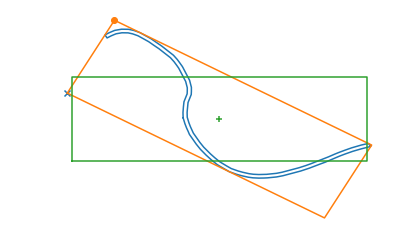

height 1.82354648385
width 2.10288064979
azimuth -60.731756373970455
lon 5.849617301136194
lat 53.39927784398523
C:\programs\gmt5\tutorial\pts_files\tmp//python_gmt_Holwerd - VA25.ps
C:\programs\gmt5\bin//gmt.exe grd2cpt -Cdeep -D -M --COLOR_NAN=0 C:\programs\gmt5\tutorial\pts_files\tmp\GEOXYZ_170221_17311_Holwerd-VA25_RD_NAP_MB_#1.nc > C:\programs\gmt5\tutorial\pts_files\tmp//custom_cpt.cpt
C:\programs\gmt5\bin//gmt.exe pscoast -Rk-2.10288064979/2.10288064979/-1.82354648385/1.82354648385 -JOa5.849617301136194/53.39927784398523/-60.731756373970455/32i -Dh -G200 -B0.03g0.03 "-B+t1.7.3.1.1 Holwerd - VA25" -W.005i -K -TdjBR+o1.4i+w2i+l -LjBR+c53+o0.8i+w1k+l+f --PS_MEDIA=A0 > "C:\programs\gmt5\tutorial\pts_files\tmp//python_gmt_Holwerd - VA25.ps"
C:\programs\gmt5\bin//gmt.exe grdimage C:\programs\gmt5\tutorial\pts_files\tmp\GEOXYZ_170221_17311_Holwerd-VA25_RD_NAP_MB_#1.nc -CC:\programs\gmt5\tutorial\pts_files\tmp//custom_cpt.cpt -R -J -Q -O -K >> "C:\programs\gmt5\tutorial\pts_files\tmp//p

In [112]:
idx_list = [2]
#label_file = r'C:\programs\gmt5\tutorial\pts_files\tmp//file_0_rd.txt'
vdlee_logo = r'C:\programs\gmt5\tutorial\pts_files\tmp//logo_vdlee_okt2016.png'
hkv_logo   = r'C:\programs\gmt5\tutorial\pts_files\tmp//HKV_lijn in water Transparant.png'

# iterate over the polygon features and plot using GMT
for idx in idx_list:
    # get the plot parameters

    bbox, rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width,title = mmbox(gdf, idx, tmp)  

    #gmt_nc = r'C:\programs\gmt5\tutorial\pts_files\sad//asdf_reprojected.nc'        

    # set out path
    gmt_out = r'C:\programs\gmt5\tutorial\pts_files\tmp//python_gmt_'+gdf.ix[idx]['OBJECTNAAM']+'.ps'
    print (gmt_out)
    # do the plotting
    apply_gmt(gmt, gmt_out, baggervakken, gmt_nc,rk_south, rk_north, rk_east, rk_west, azimuth, longitude, latitude, scale_width,title)    
